<h1 style="text-align: center;">Data Mining Project 2: Classification Analysis</h1>

<p style="text-align:center;">
    呂伯駿<br>
    Q56074085<br>
    NetDB<br>
    National Cheng Kung University<br>
    pclu@netdb.csie.ncku.edu.tw
</p>


## 1. Introduction

本次報告的目的是觀察決策樹算法所產生之規則與正確規則之差異，了解其適用情境。 報告中透過隨機分類規則合成不同資料，再進行實驗了解不同參數對分類效果的影響。


## 2. Environment

這個部分我將會說明實驗所使用的環境與使用資料集。

### 2.1 System Preferences

實驗環境如下：
- <b>Operating System</b>: macOS High Sierra (10.13.6)
- <b>CPU</b>: 1.3 GHz Intel Core i5
- <b>Memory</b>: 8 GB 1600 MHz DDR3
- <b>Programming Language</b> : Python 3.6.2

由於所用資料集皆僅有1000筆資料，實驗環境記憶體足以符合實驗需求。

### 2.2 Dataset

#### 資料參數：
本次實驗採用合成資料(預測分類)，資料集之參數設定如下：

| ID     | Number of Real Column | Number of Fake Column  |  Number of options | Counts | Full Population Index |
| ------------- |:-------------:| -----:|
| 20_r6_f6_c5 | 6 |  6 | 2| 2000|20 |
| 20_r6_f9_c5 | 6 |  9 | 2| 2000|20 |
| 20_r6_f12_c5 | 6 |  12 | 2| 2000|20 |
| 20_r6_f18_c5 | 6 |  18 | 2| 2000|20 |
| 20_r6_f24_c5 | 6 |  24 | 2| 2000|20 |
| 30_r3_f3_c5 | 3 |  3 | 5| 2000|30 |
| 30_r3_f6_c5 | 3 |  6 | 5| 2000|30 |
| 30_r3_f9_c5 | 3 |  9 | 5| 2000|30 |
| 30_r3_f12_c5 | 3 |  12 | 5| 2000|30 |
| 30_r3_f15_c5 | 3 |  15 | 5| 2000|30 |
| 50_r3_f3_c5 | 3 |  3 | 5| 2000| 50|
| 50_r3_f6_c5 | 3 |  6 | 5| 2000| 50 |
| 50_r3_f9_c5 | 3 |  9 | 5| 2000| 50 |
| 50_r3_f12_c5 | 3 |  12 | 5| 2000| 50 |
| 50_r3_f15_c5 | 3 |  15 | 5| 2000| 50 |

#### 欄位說明：
- Number of Real Column: 對分類結果有影響之欄位數目，此欄位固定為3欄
- Number of Fake Column: 對分類結果沒有影響之欄位數目
- Number of options: 每項欄位可能之數值種類
- Counts: 該資料集總資料筆數
- Full Population Index: 有效規則全數出現時之資料比例


#### 分類說明：
所預測之欄位為分類，有兩種分類 "A" & "B"。 <br>

以 50_r3_f3_c5 資料集為例，會影響分類之欄位數目為3，每種欄位有 5 種可能之數值，因此該資料集可能影響分類之規則有 5^3 = 125 種，而假欄位的數目為3，因此所有可能的資料有 15625 種，我們僅sample 出 2000筆資料，佔所有可能之 12.8%。<br>

其 Full Population Index 為 50，表示資料取到第1000筆時(50%資料)，125種分類規則已全數出現於資料集中，後續1000筆資料，在前三個有效欄位不會再出現新的組合。

#### 資料範例：

資料範例如下： 其中 F0~F2 為有效欄位，F3~F5為無效欄位，y為分類。

In [20]:
import pandas as pd
data = pd.read_csv('data/30/r3_f3_c5/training.csv')
data.head()

,F0,F1,F2,F3,F4,F5,y
0,0,1,4,1,4,3,A
1,0,3,2,1,2,4,A
2,0,1,1,3,3,1,A
3,0,4,3,2,2,4,B
4,1,2,3,2,3,1,A


所有規則出現之趨勢變化如下。 index 為 30 時數值為 1 表示到第 600 筆(2000*0.3=600)資料時，125 種可能規則已全數出現。

In [26]:
df = pd.DataFrame([['0.56', '0.8', '0.928', '0.968', '0.992', '1','1','1','1','1','1','1','1','1','1','1','1','1','1']],
 index=['0'],
 columns=['5', '10','15','20','25','30','35','40','45','50','55','60','65','70','75','80','85','90','95',])
df.head()

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
0,0.56,0.8,0.928,0.968,0.992,1,1,1,1,1,1,1,1,1,1,1,1,1,1



## 3. Implementation

### 3.1 Data generation

資料產生分為三個階段，(1)規則樹的產生，(2)將規則樹轉化為規則陣列，(3)以及根據該規則陣列產生資料集。

若有三個欄位5種數值，則會產生 3 層，最終 125 leaves 之樹

若僅有兩個欄位，每個欄位兩種數值，則為基本二元樹，產生之樹呈現上如下圖：

![](https://i.imgur.com/kHqxlbp.png)

若第一個欄位數值為 0 ，第二個欄位數值為 1，則分類為 B


### 3.2 Classification

由於目的是比較算法產生之分類規則與實際制定之分類規則上之差異，我們需採用可解釋結果之模型，因此分類上使用 scikit learn Package 之 Decision Tree 算法進行分類。


## 4. Analysis

實驗將比較改變不同 選項數，training data 數目，不同有效與無效欄位數目，以及不同資料規則趨勢 (Full Population Index)時，其準確度，決策樹之深度，node 數目之差異。

Testing Data 固定採用 200筆資料。

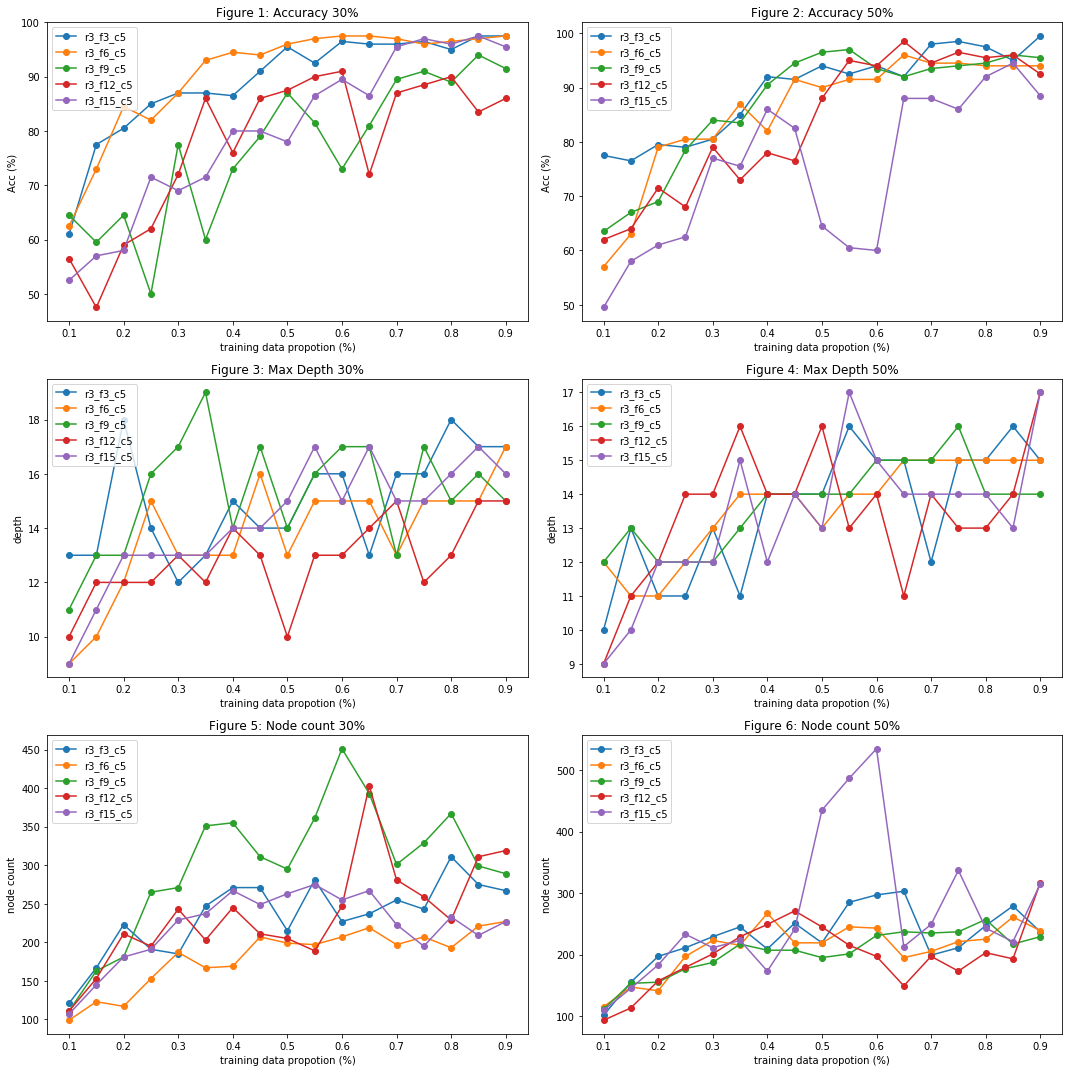

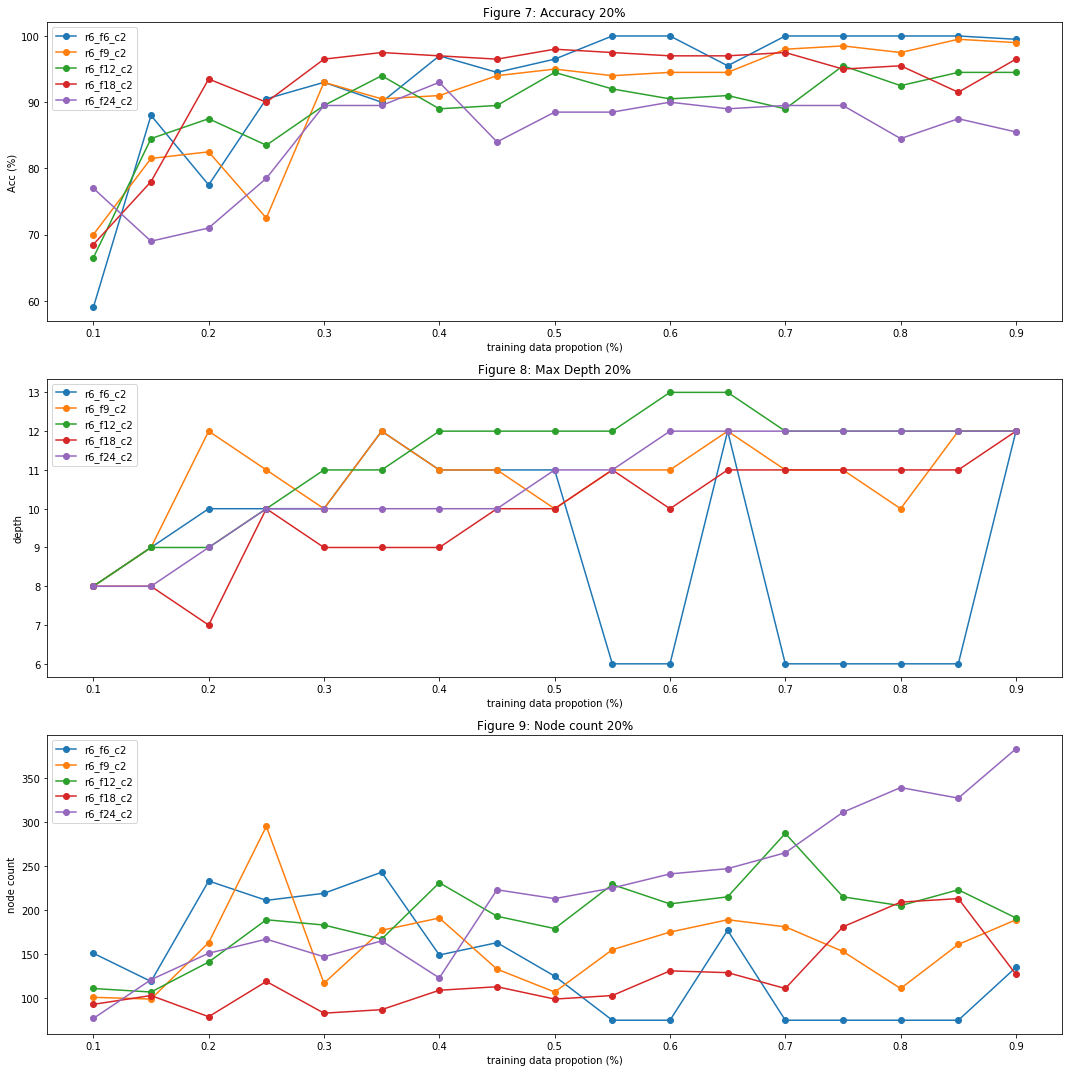

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

acc_30 = pd.read_csv('data/30/acc.csv')
depth_30 = pd.read_csv('data/30/depth.csv')
node_30 = pd.read_csv('data/30/node.csv')

acc_50 = pd.read_csv('data/50/acc.csv')
depth_50 = pd.read_csv('data/50/depth.csv')
node_50 = pd.read_csv('data/50/node.csv')

acc_20 = pd.read_csv('data/20/acc.csv')
depth_20 = pd.read_csv('data/20/depth.csv')
node_20 = pd.read_csv('data/20/node.csv')


plt.figure(figsize=(15, 15))


def ploter(legend):
    def plot_data(index, data, y_label, title):


        plt.subplot(index)
        x = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
        y_1 = data.values[0][1:]
        y_2 = data.values[1][1:]
        y_3 = data.values[2][1:]
        y_4 = data.values[3][1:]
        y_5 = data.values[4][1:]

        plt.plot(x, y_1, 'o-')
        plt.plot(x, y_2, 'o-')
        plt.plot(x, y_3, 'o-')
        plt.plot(x, y_4, 'o-')
        plt.plot(x, y_5, 'o-')
        plt.xlabel('training data propotion (%)')
        plt.ylabel(y_label)
        plt.legend(legend, loc=2);
        plt.title(title);
    return plot_data

plot_data = ploter(["r3_f3_c5", "r3_f6_c5", "r3_f9_c5", "r3_f12_c5", "r3_f15_c5"])

plot_data(321, acc_30, 'Acc (%)', 'Figure 1: Accuracy 30%')
plot_data(322, acc_50, 'Acc (%)', 'Figure 2: Accuracy 50%')

plot_data(323, depth_30, 'depth', 'Figure 3: Max Depth 30%')
plot_data(324, depth_50, 'depth', 'Figure 4: Max Depth 50%')

plot_data(325, node_30, 'node count', 'Figure 5: Node count 30%')
plot_data(326, node_50, 'node count', 'Figure 6: Node count 50%')

plt.tight_layout()
plt.show()

# plot analysis that choice = 2
plt.figure(figsize=(15, 15))
plot_binary_data = ploter(["r6_f6_c2", "r6_f9_c2", "r6_f12_c2", "r6_f18_c2", "r6_f24_c2"])
plot_binary_data(311, acc_20, 'Acc (%)', 'Figure 7: Accuracy 20%, Choice 2')
plot_binary_data(312, depth_20, 'depth', 'Figure 8: Max Depth 20%, Choice 2')
plot_binary_data(313, node_20, 'node count', 'Figure 9: Node count 20%, Choice 2')
plt.tight_layout()
plt.show()


### 4.1 Accuracy

Fig.1 可以觀察到當training data 數目增加，Accuracy 整體效果是提升的，而當無效欄位的數目增加時，其 Accuracy 上升之比率較低，變化幅度也較大，這兩點都符合預期。 而當資料集中規則母體(滿足125種規則)的資料出現時機從 30% 提升到 50% 時(所有規則在第600筆資料即全數出現，變成第1000筆才全數出現) 上升趨勢較低。 而從 Fig.2 可以看到在 training data 比例到達 50%前，若無效欄位數目越少，則其 Accuracy 較 Fig.1 時差異越大。 若無效欄位增加，Fig.1, Fig.2 在趨勢上的變化並沒有那麼明顯。 
 
而從 Fig.7 可以看到，在可能選項數為2的情況下，其準確度上升速度較選項數為5時要快。 當訓練資料數目超過有效規則之母體時(大約20%時，所有規則都會出現)，其上升趨勢到達90以上便趨緩，甚至出現 overfitting 的情形。 而無效欄位越多，準確度越低的情況在此圖中也較明顯。


### 4.2 Max Depth

從 Fig.3, Fig.4 可以看到，當 training data 數目增加，Decision Tree 的最大層數也隨之增加，雖然真實規則的層數只有 3 層，但因為每個node 都會有 5 個分支，而 decision 產生之 tree 為 Binary 的，為了有效分類結果，其層數多半超過 12 層。 由於選項較多，其層數波動幅度也大。

而從 Fig.8 可以看到，當每個欄位的選項減少時(選項為2種)，其層數相較選項為5時減少1/3，甚至可出現與真實規則相符之6層(準確度達100%)，其波動幅度減少。 但在目前的資料集上無效欄位的多寡對於最大層數的高低關聯並不明顯。


### 4.3 Node Count

觀察 Fig.5, Fig.6，基本上 training data 數目增加，node count 也會增加，但無效欄位數目對於 node count 的影響較難看出有無正相關。 而在 Fig.6 可看到當 training 為0.6時，r3_f15_c5 的 node count有顯著增加，這點即使重複實驗也會出現，搭配Fig.2來看，那時的 Acc 急遽降低，推測可能是資料集中的無效欄位在該區間出現之 pattern 使之 underfitting。

Fig.9 則是選項數為 2 時的 node count 情形，因為層數降低(8~13層)，其 node 數相對於 選項數為5時也降低了50左右。 真實規則之node數為 125，但有些資料集可以低於此數字，例如 r6_f6_c2 只需要 75 個 node 即可分類完成，其準確度甚至達到 100%，這表示在隨機產生規則的過程中，由於分類僅有兩種，該二元樹是有剪枝的可能。


在Fig.9 也可以觀察到對於無效欄位數較多之資料集，training data 若越多，則其 node count 會持續上升的現象，但無效欄位較少之資料集其上升趨勢並不明顯甚至下跌。


## 5. Conclusion

此份報告嘗試觀察改變資料集有效欄位數，無效欄位數，欄位選項數，訓練資料數目，以及規則全數出現時之資料比例對於 Decision Tree 分類結果的影響。

從實驗中發現，無效欄位的多寡對於準確率雖有影響，但畢竟無效欄位原則上不影響分類，對於 decision tree 之最大層數與 node 數間並沒有顯著的關聯。 但若無效欄位數減少到與有效欄位數接近，且分類是二分的情況下其tree甚至可達到 100% 符合真實規則。

而欄位選項數越多，雖然隨資料數目增加其準確度仍可上升，但其層數，node數的波動相對較大，此外由於decision tree 採二分法，常會出現 若 F0 Feature 數值 > 2 則如何分類之規則，但這點在真實規則並沒有關聯，真實規則每個 feature 之數字0,1,2... 應視為種類而非數字來協助分類，每種數值都有可能有不同的結果。 為了適應這一點 decision tree 增加了層數 與 node 數，但其準確度不一定會隨者此兩數之上升而有更好效果。 為此在分類時，若發現數值高低對於分類的影響並不明顯時，或許可先將數值分區，將其視為離散特徵而非連續特徵來處理。

至於規則全數出現時之資料比例，設定為 20%,30%,50%時，在達標前對準確率上升幅度會有影響，但層數與node數影響則不大。


本次實驗由於無效欄位的產生是隨機進行，因此無法排除在產生無效欄位的過程中其自然產生出有效規則的可能性，而有效規則有時也可在進一步減枝，產生更有效率之規則。  由於 decision tree 無法辨識哪些規則對於分類是 noise，甚至在分類過程中出現無效規則之影響大於有效規則的情形，這點也再次強調了篩選特徵的工作重要性。

